## Fine Sampling in Hierarchical Sampling

In [1]:
import torch

def sample_pdf(bins, weights, N_samples, det=False):
    # Compute pdf / cdf
    weights = weights + 1e-5 # Prevent nans
    pdf = weights / torch.sum(weights, -1, keepdim=True)
    cdf = torch.cumsum(pdf, -1)
    # Add 0 at the beginning
    cdf = torch.cat([torch.zeros_like(cdf[...,:1]), cdf], -1)  # (batch, len(bins))
    
    # Take uniform samples
    if det: # Deterministic sampling
        u = torch.linspace(0., 1., N_samples)
        u = u.expand(list(cdf.shape[:-1]) + [N_samples])
    else: # Random sampling
        u = torch.rand(list(cdf.shape[:-1]) + [N_samples])
    
    # Invert CDF
    u = u.contiguous()
    # For each value of u, find the bin where the CDF value equals or exceeds u.
    inds = torch.searchsorted(cdf, u, right=True)
    below = torch.max(torch.zeros_like(inds-1), inds-1) # index below u
    above = torch.clamp(inds, max=cdf.shape[-1] - 1) # index above u
    inds_g = torch.stack([below, above], -1)  # (batch, N_samples, 2)
    
    #print('cdf.shape:',cdf.shape) # torch.Size([1, 9])
    #print('bins.shape:',bins.shape) # torch.Size([1, 9])
    #print('inds_g.shape:',inds_g.shape) # torch.Size([1, 20, 2])

    # Get the values of cdf and bins at the specified indices e.g. inds_g
    # cdf_g = torch.gather(cdf, -1, inds_g) # select at dim=-1
    # bins_g = torch.gather(bins, -1, inds_g)
    matched_shape = [inds_g.shape[0], inds_g.shape[1], cdf.shape[-1]]
    cdf_g = torch.gather(cdf.unsqueeze(1).expand(matched_shape), 2, inds_g)
    bins_g = torch.gather(bins.unsqueeze(1).expand(matched_shape), 2, inds_g)
    
    #print('cdf_g.shape:',cdf_g.shape) # [1, 20, 2])
    #print('bins_g.shape:',bins_g.shape) # [1, 20, 2]
    #print('cdf_g:',cdf_g)
    #print('bins_g:',bins_g)
    
    # Interpolation
    denom = (cdf_g[...,1] - cdf_g[...,0])
    denom = torch.where(denom<1e-5, torch.ones_like(denom), denom)
    t = (u - cdf_g[...,0]) / denom # multiplication factor for interpolation
    samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])

    return samples

In [2]:
# Example input: 
num_bins = 10 # uniform coarse sampling
N_samples = 20 # number of fine samples
det = True # deterministic sampling

In [3]:
# Initialise bins and weights
z = torch.linspace(0, 1, num_bins) # Shape: [10]
w = torch.tensor([0.01, 0.02, 0.05, 0.2, 0.3, 0.5, 0.3, 0.1, 0.02, 0.01])

# Use the middle points
bins = 0.5 * (z[...,1:] + z[...,:-1])
weights = w / w.sum() # Shape: [10]
weights = weights[...,1:-1]

# Add batch
bins = bins.unsqueeze(0)
weights = weights.unsqueeze(0)

print(bins.shape) # torch.Size([1, 9])
print(weights.shape) # torch.Size([1, 8])

torch.Size([1, 9])
torch.Size([1, 8])


In [4]:
# Perform pdf sampling
samples = sample_pdf(bins, weights, N_samples, det=True)
samples = samples.squeeze(0)

In [5]:
print('z:',z.shape,z)
print('w:',w.shape,w)
print('samples:',samples.shape,samples)

z: torch.Size([10]) tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])
w: torch.Size([10]) tensor([0.0100, 0.0200, 0.0500, 0.2000, 0.3000, 0.5000, 0.3000, 0.1000, 0.0200,
        0.0100])
samples: torch.Size([20]) tensor([0.0556, 0.2824, 0.3260, 0.3696, 0.4051, 0.4341, 0.4632, 0.4922, 0.5127,
        0.5302, 0.5476, 0.5650, 0.5825, 0.5999, 0.6214, 0.6505, 0.6795, 0.7086,
        0.7684, 0.9444])


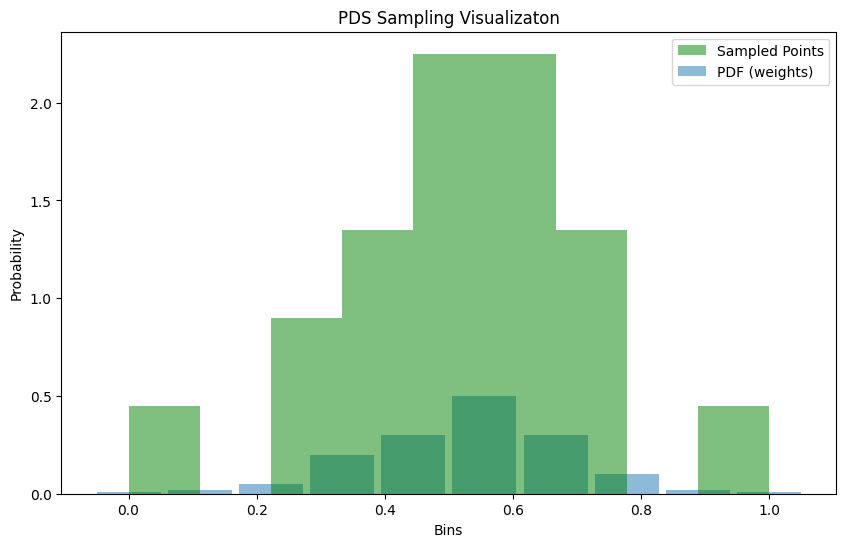

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the PDF and sampled points
plt.figure(figsize=(10,6))
plt.bar(z, w.numpy(), width=0.1, alpha=0.5, label="PDF (weights)")
# Add sampled points to the plot
plt.hist(samples.numpy(), bins=z.numpy(), density=True, alpha=0.5, color='green', label='Sampled Points')
plt.xlabel('Bins')
plt.ylabel('Probability')
plt.title('PDS Sampling Visualizaton')
plt.legend()
plt.show()

### Output:

* The blue PDF bar plot represents the pdf or weights for each bin.
* The green histogram represented the sampled points. The higher the bars represents the higher number of points got sampling at that region along the ray. 